In [1]:
import os
import numpy as np

In [2]:
# Read all files
files_paths = []
for root, _, files in os.walk("./results"):  # os.walk for recursive 
   for file in files:
       files_paths.append(os.path.join(root, file))  # Construct full path

In [3]:
files_paths

['./results\\arg_mics19-20\\arg_mics19-20_mpi_poor_conservative_c0.txt',
 './results\\arg_mics19-20\\arg_mics19-20_mpi_poor_conservative_c1.txt',
 './results\\arg_mics19-20\\arg_mics19-20_mpi_poor_conservative_c2.txt',
 './results\\arg_mics19-20\\arg_mics19-20_mpi_poor_conservative_c3.txt',
 './results\\arg_mics19-20\\arg_mics19-20_mpi_poor_conservative_c4.txt',
 './results\\arg_mics19-20\\arg_mics19-20_mpi_poor_conservative_c5.txt',
 './results\\arg_mics19-20\\arg_mics19-20_mpi_poor_conservative_c6.txt',
 './results\\arg_mics19-20\\arg_mics19-20_mpi_poor_conservative_c7.txt',
 './results\\arg_mics19-20\\arg_mics19-20_mpi_poor_conservative_c8.txt',
 './results\\arg_mics19-20\\arg_mics19-20_mpi_poor_conservative_c9.txt',
 './results\\arg_mics19-20\\arg_mics19-20_mpi_poor_nconservative_c0.txt',
 './results\\arg_mics19-20\\arg_mics19-20_mpi_poor_nconservative_c1.txt',
 './results\\arg_mics19-20\\arg_mics19-20_mpi_poor_nconservative_c2.txt',
 './results\\arg_mics19-20\\arg_mics19-20_mpi_po

In [4]:
import re

In [29]:
raw = [s for s in files_paths if re.search(r"raw_nconservative_c0", s)]
mpi_poor = [s for s in files_paths if re.search(r"mpi_poor_nconservative_c0", s)]

In [30]:
raw

['./results\\arg_mics19-20\\arg_mics19-20_raw_nconservative_c0.txt',
 './results\\ben_mics21-22\\ben_mics21-22_raw_nconservative_c0.txt',
 './results\\bfa_dhs21\\bfa_dhs21_raw_nconservative_c0.txt',
 './results\\bgd_mics19\\bgd_mics19_raw_nconservative_c0.txt',
 './results\\blz_mics15-16\\blz_mics15-16_raw_nconservative_c0.txt',
 './results\\civ_dhs21\\civ_dhs21_raw_nconservative_c0.txt',
 './results\\cmr_dhs18\\cmr_dhs18_raw_nconservative_c0.txt',
 './results\\com_mics22\\com_mics22_raw_nconservative_c0.txt',
 './results\\cub_mics19\\cub_mics19_raw_nconservative_c0.txt',
 './results\\dza_mics18-19\\dza_mics18-19_raw_nconservative_c0.txt',
 './results\\eth_dhs19\\eth_dhs19_raw_nconservative_c0.txt',
 './results\\fji_mics21\\fji_mics21_raw_nconservative_c0.txt',
 './results\\gab_dhs19-21\\gab_dhs19-21_raw_nconservative_c0.txt',
 './results\\geo_mics18\\geo_mics18_raw_nconservative_c0.txt',
 './results\\gin_dhs18\\gin_dhs18_raw_nconservative_c0.txt',
 './results\\gmb_dhs19-20\\gmb_dhs19-

In [31]:
def read_adjacency_matrix(filename):
    """
    Reads an adjacency matrix .txt file and converts it to a NumPy array.
    
    Args:
        filename: The path to the file containing the adjacency matrix.
    
    Returns:
        A NumPy array representing the adjacency matrix.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()
        
    matrix = []
    for line in lines:
        line = line.strip().split()
        matrix.append(line)
        
    return np.array(matrix, dtype = "int32")

In [32]:
read_adjacency_matrix(raw[0])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 1, 1, 0, 1, 1, 1, 0]])

In [43]:
all_adj_matrices = []
for file in mpi_poor:
    adj_matrix = read_adjacency_matrix(file)
    all_adj_matrices.append(adj_matrix)

In [44]:
all_adj_matrices

[array([[0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 1, 1, 1, 0]]),
 array([[0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 1, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 0]]),
 array([[0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 1, 0, 0, 0],
        [1, 1, 0, 1, 0, 1, 1, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 

In [45]:
import networkx as nx

In [46]:
def create_graph_from_adjacency_matrix(adj_matrix, directed=False):
    """
    Creates a NetworkX graph from an adjacency matrix.

    Args:
        adj_matrix: A NumPy 2D array representing the adjacency matrix.
        directed: If True, creates a directed graph. Otherwise, creates an undirected graph.

    Returns:
        A NetworkX graph object.  Returns None if the input is not a valid square matrix.
    """

    rows, cols = adj_matrix.shape
    if rows != cols:
        print("Adjacency matrix must be square.")
        return None

    if directed:
        graph = nx.DiGraph()  # Directed graph
    else:
        graph = nx.Graph()  # Undirected graph

    for i in range(rows):
        for j in range(cols):
            if adj_matrix[i, j] != 0:  # Add edge if the corresponding matrix element is non-zero
                if adj_matrix[i, j] == 1 or not isinstance(adj_matrix[i,j],(int, np.integer)): # unweighted
                    graph.add_edge(i, j)
                else: # weighted
                    graph.add_edge(i, j, weight=adj_matrix[i, j]) # Add edge with weight



    return graph

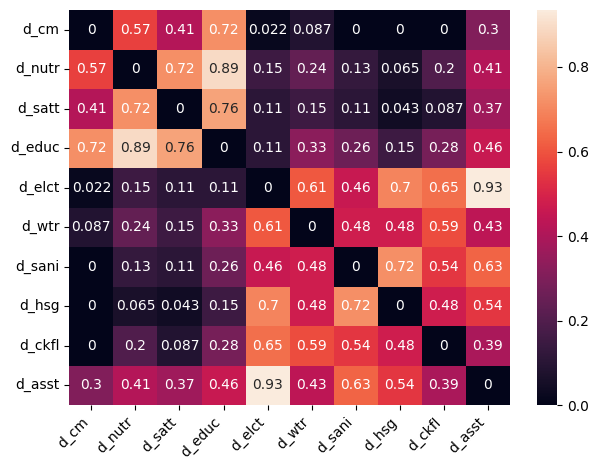

In [47]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

edges_proportions = np.sum(all_adj_matrices, axis = 0) / len(all_adj_matrices)
edges_proportions

labels = ['d_cm', 'd_nutr', 'd_satt', 'd_educ', 'd_elct', 'd_wtr', 'd_sani','d_hsg', 'd_ckfl', 'd_asst'] 
edges_proportions_df = pd.DataFrame(edges_proportions)
edges_proportions_df.index = labels

sns.heatmap(edges_proportions_df, annot=True)
plt.xticks(ticks=np.arange(len(labels)) + 0.5,  # Center labels on ticks
           labels=labels,
           rotation=45,  # Rotate for readability
           ha='right')
plt.tight_layout()
plt.show()

In [48]:
def degrees(x):
    g = create_graph_from_adjacency_matrix(x)
    return g.degree()

In [49]:
list(map(degrees, all_adj_matrices))

[DegreeView({0: 2, 1: 2, 3: 2, 4: 1, 9: 4, 5: 1, 8: 2, 6: 2, 7: 2}),
 DegreeView({0: 4, 1: 5, 2: 5, 3: 7, 9: 6, 5: 7, 6: 5, 7: 5, 8: 3, 4: 5}),
 DegreeView({0: 3, 1: 4, 2: 6, 3: 3, 6: 5, 5: 3, 9: 2, 4: 4, 7: 3, 8: 3}),
 DegreeView({0: 4, 1: 8, 2: 6, 3: 8, 5: 5, 4: 6, 6: 8, 7: 6, 8: 5, 9: 8}),
 DegreeView({1: 1, 3: 1, 4: 4, 5: 1, 7: 2, 8: 3, 9: 2, 6: 2}),
 DegreeView({0: 2, 1: 5, 3: 7, 2: 4, 4: 7, 9: 5, 6: 3, 7: 4, 8: 6, 5: 3}),
 DegreeView({0: 3, 1: 5, 3: 4, 9: 5, 2: 2, 6: 3, 5: 4, 4: 5, 7: 4, 8: 3}),
 DegreeView({0: 2, 1: 3, 3: 3, 2: 2, 4: 3, 7: 3, 8: 2, 9: 3, 5: 1, 6: 2}),
 DegreeView({0: 1, 3: 4, 1: 1, 2: 1, 9: 5, 4: 1, 5: 2, 6: 4, 7: 4, 8: 3}),
 DegreeView({0: 2, 2: 3, 3: 5, 1: 2, 6: 5, 9: 2, 4: 4, 7: 2, 8: 2, 5: 1}),
 DegreeView({0: 3, 2: 4, 3: 4, 9: 6, 1: 4, 5: 7, 4: 4, 7: 4, 8: 3, 6: 3}),
 DegreeView({1: 1, 3: 1, 4: 2, 8: 5, 9: 3, 5: 1, 6: 2, 7: 1}),
 DegreeView({0: 3, 1: 6, 3: 4, 9: 6, 2: 3, 4: 7, 7: 6, 8: 6, 5: 5, 6: 4}),
 DegreeView({0: 1, 3: 2, 9: 4, 4: 1, 5: 1, 8: 4, 6: 3, 